In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
from keras import layers
from keras.models import Sequential, load_model

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Now you can navigate to the file's location and load it
# with open('/content/drive/My Drive/path_to_file/sp500.pickle', 'rb') as file:
#     sp500 = pickle.load(file)

In [5]:
sp500 = pickle.load(open("./sp500.pickle", "rb"))

In [6]:
sp500["AMTM"]

,date,open,high,low,close,adjusted_close,volume
0,2024-09-24,32.00,34.50,29.51,29.51,29.51,11200
1,2024-09-25,31.00,31.00,28.00,28.00,28.00,15100
2,2024-09-26,28.00,28.00,27.01,27.01,27.01,22300
3,2024-09-27,27.00,27.50,25.40,25.67,25.67,163300
4,2024-09-30,26.25,32.25,23.58,32.25,32.25,18372600
5,2024-10-01,28.25,28.49,24.56,25.75,25.75,9674200


In [7]:
# from eodhd import APIClient

# api = APIClient("6608304b3de2b5.23968015")


In [8]:
def create_windows(data, win_size):
    X = []
    for i in range(len(data) - win_size):
        X.append(data[i : i + win_size])
    return np.array(X), np.array(X)[:, :, 0]

In [9]:
training_windows = []
training_labels = []
testing_windows = {}
testing_labels = {}
scalars = {}
WIN_SIZE = 7
for symbol, stock in sp500.items():
    # print(symbol)
    # if symbol != "AAPL":
    #     continue

    # stock = pd.DataFrame(
    #     api.get_eod_historical_stock_market_data(
    #         symbol=f"{symbol}.US",
    #         period="d",
    #         order="a",
    #     )
    # )

    stock.set_index(stock.columns[0], inplace=True)
    stock.index = pd.to_datetime(stock.index)
    stock["log_return"] = np.log(
        stock["adjusted_close"] / stock["adjusted_close"].shift(1)
    )
    stock["log_return"] = stock["log_return"].fillna(0)
    stock = stock[["log_return", "volume"]]
    stock = stock.astype(np.float32)

    train = stock.loc[stock[stock.index < "2021-01-01"].index]
    test = stock.loc[stock[stock.index >= "2021-01-01"].index]

    # print(train)

    scaler = StandardScaler()

    if not train.empty:
        train_scaled = scaler.fit_transform(train)
        test_scaled = scaler.transform(test)
        train_windows, train_labels = create_windows(train_scaled, WIN_SIZE)
        test_windows, test_labels = create_windows(test_scaled, WIN_SIZE)
        training_windows.append(train_windows)
        training_labels.append(train_labels)
        testing_windows[symbol] = test_windows
        testing_labels[symbol] = test_labels
    else:
        # If the stock doesn't have enough data to cover one window size, skip it
        if len(test) < WIN_SIZE:
            continue
        test_scaled = scaler.fit_transform(test)
        test_windows, test_labels = create_windows(test_scaled, WIN_SIZE)
        testing_windows[symbol] = test_windows
        testing_labels[symbol] = test_labels
        scaler.fit(test)

    scalars[symbol] = scaler

training_windows = np.concatenate(training_windows)
training_labels = np.concatenate(training_labels)

# training_windows = np.array(training_windows[0])
# training_labels = np.array(training_labels[0])
# testing_windows = np.array(testing_windows[0])
# testing_labels = np.array(testing_labels[0])

In [10]:
training_windows[0], training_labels[0]

(array([[-0.02427561, -0.9376119 ],
        [ 0.4862421 , -0.8208213 ],
        [-0.02427561, -0.9376119 ],
        [-1.8388834 , -0.88055396],
        [-0.4171154 , -0.86985564],
        [-0.02427561, -0.88055396],
        [-0.81678617, -0.9144323 ]], dtype=float32),
 array([-0.02427561,  0.4862421 , -0.02427561, -1.8388834 , -0.4171154 ,
        -0.02427561, -0.81678617], dtype=float32))

In [11]:
print(
    training_windows.shape,
    training_labels.shape,
    len(testing_windows),
    len(testing_labels),
)

(3580431, 7, 2) (3580431, 7) 502 502


In [12]:
# pickle.dump(scalars, open("scalars.pickle", "wb"))

# Model definition and training

## AE

In [13]:
training_windows.shape[1], training_windows.shape[2]

(7, 2)

In [14]:
ae = Sequential(name="autoencoder")
ae.add(layers.InputLayer(shape=(WIN_SIZE, 2)))
ae.add(layers.LSTM(32))
# ae.add(layers.Dropout(rate=0.2))
ae.add(layers.RepeatVector(WIN_SIZE))
ae.add(layers.LSTM(16, return_sequences=True))
# ae.add(layers.Dropout(rate=0.2))
ae.add(layers.TimeDistributed(layers.Dense(1)))
ae.add(layers.Reshape((WIN_SIZE,)))
ae.compile(optimizer="adam", loss="mae")
ae.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,633 (29.82 KB)

 Trainable params: 7,633 (29.82 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# early_stopping = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     restore_best_weights=True,
# )

# history = ae.fit(
#     training_windows,
#     training_labels,
#     epochs=30,
#     batch_size=32,
#     validation_split=0.2,
#     shuffle=False,
#     callbacks=[early_stopping],
# )

In [16]:
# ae.save("autoencoder.keras")
# with open("history.pickle", "wb") as f:
#     pickle.dump(history.history, f)

with open("history.pickle", "rb") as f:
    history = pickle.load(f)

ae = load_model("autoencoder.keras")

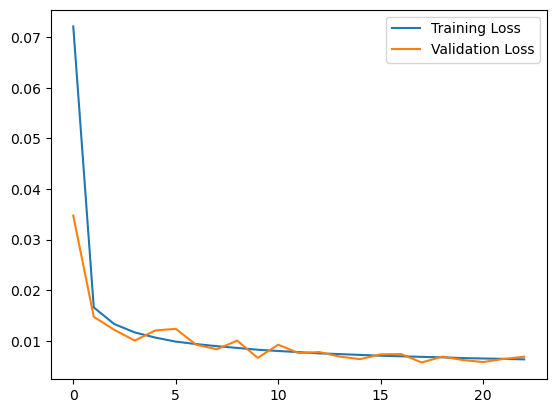

In [17]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [18]:
train_predictions = ae.predict(training_windows)
train_mae_loss = np.mean(np.abs(train_predictions - training_labels), axis=1)

111889/111889 ━━━━━━━━━━━━━━━━━━━━ 75s 673us/step


In [23]:
THRESHOLD = np.percentile(train_mae_loss, 90)
THRESHOLD

0.007558480836451054

In [24]:
import ipywidgets as widgets
from IPython.display import HTML

In [28]:
fig = go.FigureWidget()
fig_returns = go.FigureWidget()
anomaly_list = widgets.Output()


def on_click(stock):
    test_pred = ae.predict(testing_windows[stock], verbose=0)
    test_mae_loss = np.mean(np.abs(test_pred - testing_labels[stock]), axis=1)

    # threshold = np.percentile(test_mae_loss, 95)

    # is_anomaly = test_mae_loss > threshold
    is_anomaly = test_mae_loss > THRESHOLD
    plot_data = sp500[stock].loc[sp500[stock].index >= "2021-01-01"]
    anomalies = plot_data[:-WIN_SIZE][is_anomaly]
    with anomaly_list:
        anomaly_list.clear_output()
        anomalies_data = anomalies.loc[:, ["adjusted_close", "log_return"]]
        anomalies_data["return%"] = (np.exp(anomalies_data["log_return"]) - 1) * 100
        anomalies_data["period_mae"] = test_mae_loss[is_anomaly]
        anomalies_data["threshold"] = THRESHOLD
        anomalies_data.index.name = "start_of_period"
        display(
            HTML(
                "<div style='overflow: auto; height: 500px; width: fit-content'>"
                + anomalies_data.to_html()
                + "</div>"
            )
        )
    fig.data = []
    fig_returns.data = []

    fig.add_trace(
        px.line(
            data_frame=plot_data,
            x=plot_data.index,
            y="adjusted_close",
            title=f"Stock Price and Anomalies for {stock}",
            width=1200,
        ).data[0]
    )
    fig_returns.add_trace(
        px.line(
            data_frame=plot_data,
            x=plot_data.index,
            y="log_return",
            title=f"Stock Returns and Anomalies for {stock}",
            width=1200,
        ).data[0]
    )

    fig.add_trace(
        go.Scatter(
            x=anomalies.index,
            y=plot_data.loc[anomalies.index, "adjusted_close"],
            mode="markers",
            marker=dict(color="red", size=3),
            name="Anomaly",
        )
    )
    fig_returns.add_trace(
        go.Scatter(
            x=anomalies.index,
            y=plot_data.loc[anomalies.index, "log_return"],
            mode="markers",
            marker=dict(color="red", size=3),
            name="Anomaly",
        )
    )

    fig.update_layout(
        title=f"Stock Price and Anomalies for {stock}",
        xaxis_title="Time",
        yaxis_title="Price",
    )
    fig_returns.update_layout(
        title=f"Stock Returns and Anomalies for {stock}",
        xaxis_title="Time",
        yaxis_title="log Returns",
    )

    # with output:
    #     output.outputs = []
    # fig.show()

In [29]:
stock_dropdown = widgets.Dropdown(
    options=testing_windows.keys(),
    description="Stock:",
    disabled=False,
)

submit_button = widgets.Button(description="Submit")
submit_button.on_click(lambda _: on_click(stock_dropdown.value))

toolbar = widgets.HBox([stock_dropdown, submit_button])
plots_display = widgets.VBox([fig, fig_returns], layout=widgets.Layout(width="70%"))
anomalies_display = widgets.VBox(
    [
        widgets.HTML("<h2>List of Anomalies</h2>"),
        anomaly_list,
    ]
)
results_display = widgets.HBox(
    [plots_display, anomalies_display],
    layout=widgets.Layout(display="flex"),
)
ui = widgets.VBox([toolbar, results_display])

display(ui)